# Polynomial and Spline Fitting

## Polynomial Fitting

We are given data $u:1,...,u_m \in R$ and $v_1,...,v_m \in R$, and hope to approximately fit a polynomial of the form:

$$p(u) = x_1 + x_2u + ... + x_nu^{n-1}$$

to the data. For each $x$ form the vector of errors:

$$e = (p(u_1) - v_1,..., p(u_m) - v_m)$$

To find the polynomial that minimizes the norm of the error, we solve the norm approximation problem:

$$minimize \hspace{1cm} ||e|| = ||Ax - v||$$

with variable $x\in R^{n}$, where $A_{ij} = u_{i}^{j-1}, i = 1,...,m,j=1,...,n$

The following picture shpws an example with $m=40$ data points and $n=6$ (i.e., polynomials of maximum degree 5), for the $l_2$ and $l_{\infty}-norms$

<img src="https://drive.google.com/uc?export=view&id=14VTKntNCfbW2cNAaMmwcZly8hE0fuBHM" width="600" align="center"/>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


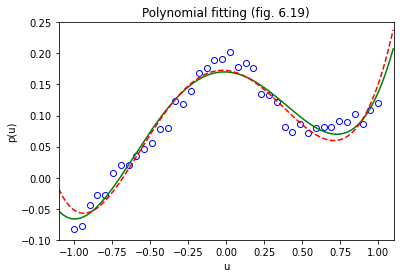

In [ ]:
# Figures 6.19 and 6.20, page 332.
# Polynomial and spline fitting.

from cvxopt import lapack, solvers, matrix, mul
from cvxopt.modeling import op, variable, max
try: import pylab
except ImportError: pylab_installed = False
else: pylab_installed = True
from pickle import load
solvers.options['show_progress'] = 0

data = load(open("/content/drive/MyDrive/Optimizacion_Convexa/03_Applications_to_modelling/Polynomial_and_Spline_Fitting/polapprox.bin",'rb'))
t, y = data['t'], data['y']
m = len(t)

# LS fit of 5th order polynomial
#
#     minimize ||A*x - y ||_2

n = 6
A = matrix( [[t**k] for k in range(n)] )
xls = +y
lapack.gels(+A,xls)
xls = xls[:n]

# Chebyshev fit of 5th order polynomial
#
#     minimize ||A*x - y ||_inf

xinf = variable(n)
op( max(abs(A*xinf - y)) ).solve()
xinf = xinf.value

if pylab_installed:
    pylab.figure(1, facecolor='w')
    pylab.plot(t, y, 'bo', mfc='w', mec='b')
    nopts = 1000
    ts = -1.1 + (1.1 - (-1.1))/nopts * matrix(list(range(nopts)), tc='d')
    yls = sum( xls[k] * ts**k  for k in range(n) )
    yinf = sum( xinf[k] * ts**k  for k in range(n) )
    pylab.plot(ts,yls,'g-', ts, yinf, '--r')
    pylab.axis([-1.1, 1.1, -0.1, 0.25])
    pylab.xlabel('u')
    pylab.ylabel('p(u)')
    pylab.title('Polynomial fitting (fig. 6.19)')


## Spline Fitting

The following figure shows the same data as the previous examole,, and two optimal fits with cubic splines. The interval $[−1, 1]$ is divided into three equal intervals, and we consider piecewise polynomials, with maximum degree 3, with continuous first and second derivatives. The dimension of this subspace of functions is 6, the same as the dimension of polynomials with maximum degree 5.

<img src="https://drive.google.com/uc?export=view&id=1WrKa7U0LKtnnUfG0EAGRolWrPXb8jLwt" width="600" align="center"/>

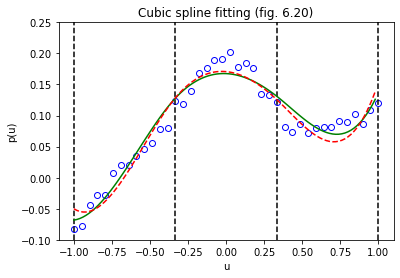

In [ ]:
# Fit of cubic spline
#
#     f(t) = p1(t)   -1   <= t <= -1/3
#          = p2(t)   -1/3 <= t <=  1/3
#          = p3(t)    1/3 <= t <=  1
#
#     p1(t) = x0 + x1*t + x2*t^2 + x3*t^3    -1   <= t <= -1/3
#     p2(t) = x4 + x5*t + x6*t^2 + x7*t^3    -1/3 <= t <=  1/3
#     p3(t) = x8 + x9*t + x10*t^2 + x11*t^3   1/3 <= t <=  1
#
# with constraints
#
#     p1(-1/3) = p2(-1/3),
#     p1'(-1/3) = p2'(-1/3)
#     p1''(-1/3) = p2''(-1/3)
#     p2(1/3) = p3(1/3),
#     p2'(1/3) = p3'(1/3)
#     p2''(1/3) = p3''(1/3)


n = 12
u1, u2 = -1.0/3, 1.0/3
I1 = [ k for k in range(m) if -1.0  <= t[k] < u1 ]
I2 = [ k for k in range(m) if  u1 <= t[k] < u2 ]
I3 = [ k for k in range(m) if  u2 <= t[k] <= 1.0 ]
m1, m2, m3 = len(I1), len(I2), len(I3)
A = matrix(0.0, (m,n))
for k in range(4):
    A[I1,k] = t[I1]**k
    A[I2,k+4] = t[I2]**k
    A[I3,k+8] = t[I3]**k

G = matrix(0.0, (6,n))

# p1(u1) = p2(u1),  p1(u2) = p2(u2)
G[0, list(range(8))]  =  \
    1.0,  u1,  u1**2,  u1**3, -1.0, -u1, -u1**2, -u1**3
G[1, list(range(4,12))] =  \
    1.0,  u2,  u2**2,  u2**3, -1.0, -u2, -u2**2, -u2**3

# p1'(u1) = p2'(u1),  p1'(u2) = p2'(u2)
G[2, [1,2,3,5,6,7]] = 1.0,  2*u1,  3*u1**2, -1.0, -2*u1, -3*u1**2
G[3, [5,6,7,9,10,11]]  =  1.0,  2*u2,  3*u2**2,  -1.0, -2*u2, -3*u2**2

# p1''(u1) = p2''(u1),  p1''(u2) = p2''(u2)
G[4, [2,3,6,7]]  =  2,  6*u1, -2, -6*u1
G[5, [6,7,10,11]]  =  2,  6*u2, -2, -6*u2


# LS fit
#
#     minimize    (1/2) * || A*x - y ||_2^2
#     subject to  G*x = h
#
# Solve as a linear equation
#
#     [ A'*A  G' ] [ x ]   [ A'*y ]
#     [ G     0  ] [ y ] = [ 0    ].

K = matrix(0.0, (n+6,n+6))
K[:n,:n] = A.T * A
K[n:,:n] = G
xls = matrix(0.0, (n+6,1))
xls[:n] = A.T * y
lapack.sysv(K, xls)
xls = xls[:n]


# Chebyshev fit
#
#     minimize    || A*x - y ||_inf
#     subject to  G*x = h

xcheb = variable(12)
op( max(abs(A*xcheb - y)), [G*xcheb == 0]).solve()
xcheb = xcheb.value

if pylab_installed:
    pylab.figure(2, facecolor='w')
    nopts  = 100
    ts = -1.0 + (1.0 - (-1.0))/nopts * matrix(list(range(nopts)), tc='d')
    I1 = [ k for k in range(nopts) if -1.0  <= ts[k] < u1 ]
    I2 = [ k for k in range(nopts) if  u1 <= ts[k] < u2 ]
    I3 = [ k for k in range(nopts) if  u2 <= ts[k] <= 1.0 ]
    yls = matrix(0.0, (nopts,1))
    yls[I1] = sum( xls[k]*ts[I1]**k for k in range(4) )
    yls[I2] = sum( xls[k+4]*ts[I2]**k for k in range(4) )
    yls[I3] = sum( xls[k+8]*ts[I3]**k for k in range(4) )
    ycheb = matrix(0.0, (nopts,1))
    ycheb[I1] = sum( xcheb[k]*ts[I1]**k for k in range(4) )
    ycheb[I2] = sum( xcheb[k+4]*ts[I2]**k for k in range(4) )
    ycheb[I3] = sum( xcheb[k+8]*ts[I3]**k for k in range(4) )

    pylab.plot(t, y, 'bo', mfc='w', mec='b')
    pylab.plot([-1.0, -1.0], [-0.1, 0.25], 'k--',
        [-1./3,-1./3], [-0.1, 0.25], 'k--',
        [1./3,1./3], [-0.1, 0.25], 'k--', [1,1], [-0.1, 0.25], 'k--')
    pylab.plot(ts, yls, '-g', ts, ycheb, '--r')
    pylab.axis([-1.1, 1.1, -0.1, 0.25])
    pylab.xlabel('u')
    pylab.ylabel('p(u)')
    pylab.title('Cubic spline fitting (fig. 6.20)')
    
    pylab.show()